# imports

In [86]:
import os
import sys
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from pandas import DataFrame
from typing import Dict, List
from datetime import datetime
from tqdm import tqdm
import json
import importlib

In [91]:
import questionnaire
importlib.reload(questionnaire)
from questionnaire import (
    relevance_questions,
    relevance_labels,
    relevant_prompt,
    agreement_questions,
    agreement_labels,
    agreement_prompt,
    compute_mfq
)

In [164]:
from openai import OpenAI
from together import Together
import anthropic


# models.py

In [18]:
MODELS = dict(
    {
        "openai/gpt-3.5-turbo": {
            "company": "openai",
            "model_class": "OpenAIModel",
            "model_name": "gpt-3.5-turbo",
        },
        "openai/gpt-4o-mini": {
            "company": "openai",
            "model_class": "OpenAIModel",
            "model_name": "gpt-4o-mini",
        },
        "openai/gpt-4o": {
            "company": "openai",
            "model_class": "OpenAIModel",
            "model_name": "gpt-4o",
        },
        "meta/llama-3.1-70b": {
            "company": "meta",
            "model_class": "TogetherModel",
            "model_name": "meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo",
        },
        "mistral/mixtral-8x7b": {
            "company": "mistral",
            "model_class": "TogetherModel",
            "model_name": "mistralai/Mixtral-8x7B-Instruct-v0.1",
        },
        "anthropic/claude-3-haiku": {
            "company": "anthropic",
            "model_class": "AnthropicModel",
            "model_name": "claude-3-haiku-20240307",
        },
        "anthropic/claude-3.5-sonnet": {
            "company": "anthropic",
            "model_class": "AnthropicModel",
            "model_name": "claude-3-5-sonnet-20240620",
        },
    }
)

In [9]:
def get_api_key(company_identifier: str) -> str:
    """
    Helper Function to retrieve API key from files
    """
    path_key = f"../api_keys/{company_identifier}_key.txt"

    if os.path.exists(path_key):
        with open(path_key, encoding="utf-8") as f:
            key = f.read()
        return key

    raise ValueError(f"API KEY not available at: {path_key}")

def get_timestamp():
    """
    Generate timestamp of format Y-M-D_H:M:S
    """
    return datetime.now().strftime("%Y-%m-%d_%H:%M:%S")


In [183]:
####################################################################################
# MODEL WRAPPERS
####################################################################################


class LanguageModel:
    """ Generic LanguageModel Class"""

    def __init__(self, model_name):
        assert model_name in MODELS, f"Model {model_name} is not supported!"

        # Set some default model variables
        self._model_id = model_name
        self._model_name = MODELS[model_name]["model_name"]
        self._company = MODELS[model_name]["company"]

    def get_model_id(self):
        """Return model_id"""
        return self._model_id

    def get_greedy_answer(
        self, messages: List[Dict], max_tokens: int
    ) -> str:
        """
        Gets greedy answer for prompt_base

        :param prompt_base:     base prompt
        :param prompt_sytem:    system instruction for chat endpoint of OpenAI
        :return:                answer string
        """

    def get_top_p_answer(
        self,
        messages: List[Dict],
        max_tokens: int,
        temperature: float,
        top_p: float,
    ) -> str:
        """
        Gets answer using sampling (based on top_p and temperature)

        :param prompt_base:     base prompt
        :param prompt_sytem:    system instruction for chat endpoint of OpenAI
        :param max_tokens       max tokens in answer
        :param temperature      temperature for top_p sampling
        :param top_p            top_p parameter
        :return:                answer string
        """


class OpenAIModel(LanguageModel):
    """OpenAI API Wrapper"""
    def __init__(self, model_name: str):
        super().__init__(model_name)
        assert MODELS[model_name]["model_class"] == "OpenAIModel", (
            f"Errorneous Model Instatiation for {model_name}"
        )

        api_key = get_api_key("openai")
        self.openai = OpenAI(api_key = api_key)

    def _prompt_request(
        self,
        messages: List[Dict],
        max_tokens: int,
        temperature: float = 0.0,
        top_p: float = 1.0,
        frequency_penalty: float = 0.0,
        presence_penalty: float = 0.0,
        logprobs: int = 0,
        stop: List = ["Human:", " AI:"],
        echo: bool = False,
    ):
        success = False
        t = 0

        MAX_RETRIES = 5
        response = None

        while not success and t < MAX_RETRIES:
            try:
                # Query ChatCompletion endpoint
                response = self.openai.chat.completions.create(
                    model=self._model_name,
                    messages=messages,
                    temperature=temperature,
                    top_p=top_p,
                    max_tokens=max_tokens,
                    frequency_penalty=frequency_penalty,
                    presence_penalty=presence_penalty,
                )

                # Set success flag
                success = True

            except:
                time.sleep(API_TIMEOUTS[t])
                t = min(t + 1, len(API_TIMEOUTS) - 1)

        return response

    def get_greedy_answer(
        self, messages:List[Dict], max_tokens: int
    ) -> str:
        return self.get_top_p_answer(
            messages=messages,
            max_tokens=max_tokens,
            temperature=0,
            top_p=1.0,
        )

    def get_top_p_answer(
        self,
        messages: List[Dict],
        max_tokens: int,
        temperature: float,
        top_p: float,
    ) -> str:
        result = {
            "timestamp": get_timestamp(),
        }

        # (1) Top-P Sampling
        response = self._prompt_request(
            messages=messages,
            max_tokens=max_tokens,
            temperature=temperature,
            top_p=top_p,
            frequency_penalty=0.0,
            presence_penalty=0.0,
            logprobs=1,
            stop=["Human:", " AI:"],
            echo=False,
        )

        completion = response.choices[0].message.content.strip()

        result["answer"] = completion.strip()

        return result

class TogetherModel(LanguageModel):
    """Together API Wrapper"""
    def __init__(self, model_name: str):
        super().__init__(model_name)
        assert MODELS[model_name]["model_class"] == "TogetherModel", (
            f"Errorneous Model Instatiation for {model_name}"
        )

        api_key = get_api_key("together")
        self.together = Together(api_key = api_key)

    def _prompt_request(
        self,
        messages: List[Dict],
        max_tokens: int,
        temperature: float = 0.0,
        top_p: float = 1.0,
        frequency_penalty: float = 0.0,
        presence_penalty: float = 0.0,
        logprobs: int = 0, # changed
        stop: List = ["Human:", " AI:"],
        echo: bool = False,
    ):
        success = False
        t = 0

        MAX_RETRIES = 5
        response = None

        while not success and t < MAX_RETRIES:
            try:
                # Query ChatCompletion endpoint
                response = self.together.chat.completions.create(
                    model=self._model_name,
                    messages=messages,
                    temperature=temperature,
                    top_p=top_p,
                    max_tokens=max_tokens,
                    frequency_penalty=frequency_penalty,
                    presence_penalty=presence_penalty,
                )

                # Set success flag
                success = True

            except:
                time.sleep(API_TIMEOUTS[t])
                t = min(t + 1, len(API_TIMEOUTS) - 1)

        return response

    def get_greedy_answer(
        self, messages:List[Dict], max_tokens: int
    ) -> str:
        return self.get_top_p_answer(
            messages=messages,
            max_tokens=max_tokens,
            temperature=0,
            top_p=1.0,
        )

    def get_top_p_answer(
        self,
        messages: List[Dict],
        max_tokens: int,
        temperature: float,
        top_p: float,
    ) -> str:
        result = {
            "timestamp": get_timestamp(),
        }

        # (1) Top-P Sampling
        response = self._prompt_request(
            messages=messages,
            max_tokens=max_tokens,
            temperature=temperature,
            top_p=top_p,
            frequency_penalty=0.0,
            presence_penalty=0.0,
            logprobs=1,
            stop=["Human:", " AI:"],
            echo=False,
        )

        completion = response.choices[0].message.content.strip()

        result["answer"] = completion.strip()

        return result
    
class AnthropicModel(LanguageModel):
    """Anthropic API Wrapper"""
    
    def __init__(self, model_name: str):
        super().__init__(model_name)
        assert MODELS[model_name]["model_class"] == "AnthropicModel", (
            f"Erroneous Model Instantiation for {model_name}"
        )

        api_key = get_api_key("anthropic")
        self._anthropic_client = anthropic.Anthropic(api_key=api_key)

    def _prompt_request(
        self,
        messages: List[Dict],
        max_tokens: int,
        temperature: float = 0.0,
        top_p: float = 1.0,
    ):
        success = False
        t = 0

        while not success and t < len(API_TIMEOUTS):
            try:
                response = self._anthropic_client.messages.create(
                    model=self._model_name,
                    messages=messages,
                    max_tokens=max_tokens,
                    temperature=temperature,
                    top_p=top_p,
                )
                success = True
            except Exception as e:
                print(f"API call failed: {e}")
                time.sleep(API_TIMEOUTS[t])
                t += 1

        if not success:
            raise Exception("Failed to get response from Anthropic API after multiple retries")

        return response

    def get_top_p_answer(
        self,
        messages: List[Dict],
        max_tokens: int,
        temperature: float,
        top_p: float,
    ) -> str:
        result = {
            "timestamp": get_timestamp(),
        }

        response = self._prompt_request(
            messages=messages,
            max_tokens=max_tokens,
            temperature=temperature,
            top_p=top_p,
        )

        result["answer"] = response.content[0].text.strip()
        return result

    def get_greedy_answer(
        self, messages: List[Dict], max_tokens: int
    ) -> str:
        return self.get_top_p_answer(
            messages=messages,
            max_tokens=max_tokens,
            temperature=0,
            top_p=1.0,
        )

In [13]:
####################################################################################
# MODEL CREATOR
####################################################################################


def create_model(model_name):
    """Init Models from model_name only"""
    if model_name in MODELS:
        class_name = MODELS[model_name]["model_class"]
        cls = getattr(sys.modules[__name__], class_name)
        return cls(model_name)

    raise ValueError(f"Unknown Model '{model_name}'")

# mfq

In [179]:
def prompt_mfq(model, system_prompt: str = ""):
    responses = []
    print("Relevance questions")
    for i in tqdm(range(len(relevance_questions))):
        full_prompt = relevant_prompt + " " + relevance_questions[i] + " Label: " 
        response = model.get_top_p_answer(
            messages = [ 
                # { "role" : "system", "content": system_prompt }, 
                { "role" : "user", "content" : full_prompt } ],
            # messages = [ { "role":"user", "content":full_prompt } ],
            max_tokens = 10,
            temperature = 1.0,
            top_p = 1.0
        )
        value = semantic_token_to_value("relevance", response['answer'])
        responses.append(value)
        # print(f"{i} - {response['answer']}, {value}")

    print("Agreement questions")
    for i in tqdm(range(len(agreement_questions))):
        full_prompt = agreement_prompt + " " + agreement_questions[i] + " Label: "
        response = model.get_top_p_answer(
            messages = [ 
                # { "role" : "system", "content": system_prompt }, 
                { "role" : "user", "content" : full_prompt } ],
            max_tokens = 10,
            temperature = 1.0,
            top_p = 1.0,
        )
        value = semantic_token_to_value("agreement", response['answer'])
        responses.append(value)
    # return responses

    responses_tensor = torch.tensor(responses)
    responses_tensor = responses_tensor.float()
    return compute_mfq(responses_tensor)


In [95]:
def semantic_token_to_value(question_type:str, response:str) -> int:
    response = response.strip().lower()
    full_text_to_label = {}

    # Dictionary to map full text responses to their corresponding labels
    if question_type == "relevance":
        full_text_to_label = {
            "irrelevant": "a",
            "not very relevant": "b",
            "slightly relevant": "c",
            "somewhat relevant": "d",
            "very relevant": "e",
            "extremely relevant": "f"
        }
    else:
        full_text_to_label = {
            "strongly disagree": "a",
            "moderately disagree": "b",
            "slightly disagree": "c",
            "slightly agree": "d",
            "moderately agree": "e",
            "strongly agree": "f"
        }
    
    # First, try to match the full text response
    for text, label in full_text_to_label.items():
        if text in response:
            return relevance_labels[label]
    
    # If full text matching fails, try to match the label directly
    for label in relevance_labels:
        if label in response:
            return relevance_labels[label]
    
    # If no match is found, return None or raise an exception
    return None  # or raise ValueError("Unable to map response to a relevance value")

In [176]:
gpt4omini = create_model("openai/gpt-4o-mini")
llama3170b = create_model("meta/llama-3.1-70b")
mixtral8x7b = create_model("mistral/mixtral-8x7b")
claude3haiku = create_model("anthropic/claude-3-haiku")

In [158]:
all_scores = {}

In [148]:
all_scores['vanilla'] = prompt_mfq(gpt4omini)
all_scores['liberal'] = prompt_mfq(gpt4omini, system_prompt="You are a liberal.")
all_scores['conservative'] = prompt_mfq(gpt4omini, system_prompt="You are a conservative.")
all_scores['purity_max'] = prompt_mfq(gpt4omini, system_prompt="You believe that some people are more important than others.")

Relevance questions


100%|██████████| 15/15 [00:07<00:00,  1.92it/s]


Agreement questions


100%|██████████| 16/16 [00:10<00:00,  1.49it/s]


Relevance questions


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


Agreement questions


100%|██████████| 16/16 [00:10<00:00,  1.56it/s]


Relevance questions


100%|██████████| 15/15 [00:08<00:00,  1.79it/s]


Agreement questions


100%|██████████| 16/16 [00:09<00:00,  1.77it/s]


Relevance questions


100%|██████████| 15/15 [00:08<00:00,  1.72it/s]


Agreement questions


100%|██████████| 16/16 [00:09<00:00,  1.71it/s]


In [169]:
all_scores['gpt-4o-mini'] = prompt_mfq(gpt4omini)
all_scores['llama-3.1-70b'] = prompt_mfq(llama3170b)
all_scores['mixtral-8x7b'] = prompt_mfq(mixtral8x7b)

Relevance questions


100%|██████████| 15/15 [00:09<00:00,  1.65it/s]


Agreement questions


100%|██████████| 16/16 [00:09<00:00,  1.63it/s]


Relevance questions


100%|██████████| 15/15 [00:08<00:00,  1.84it/s]


Agreement questions


100%|██████████| 16/16 [00:09<00:00,  1.66it/s]


Relevance questions


100%|██████████| 15/15 [00:08<00:00,  1.81it/s]


Agreement questions


100%|██████████| 16/16 [00:08<00:00,  1.98it/s]


In [184]:
all_scores['claude-3-haiku'] = prompt_mfq(claude3haiku)

Relevance questions


  0%|          | 0/15 [00:00<?, ?it/s]


TypeError: get_top_p_answer() missing 1 required positional argument: 'system'

In [185]:
def plot_radar_chart(scores_list, labels):
    # Define the attributes
    # attributes = ['Care', 'Fairness', 'Loyalty', 'Authority', 'Sanctity', 'Progressivism']
    attributes = ['Care', 'Fairness', 'Loyalty', 'Authority', 'Sanctity']
    
    # Number of attributes
    num_attrs = len(attributes)
    
    # Calculate the angle for each attribute
    angles = [n / float(num_attrs) * 2 * np.pi for n in range(num_attrs)]
    angles += angles[:1]  # Complete the circle
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))
    
    # Plot each dataset
    for scores, label in zip(scores_list, labels):
        values = scores + scores[:1]  # Complete the polygon
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=label)
        ax.fill(angles, values, alpha=0.1)
    
    # Set the labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(attributes)
    
    # Set y-axis limits
    ax.set_ylim(0, 5)
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    
    plt.title("MFQ by model")
    plt.tight_layout()
    plt.show()


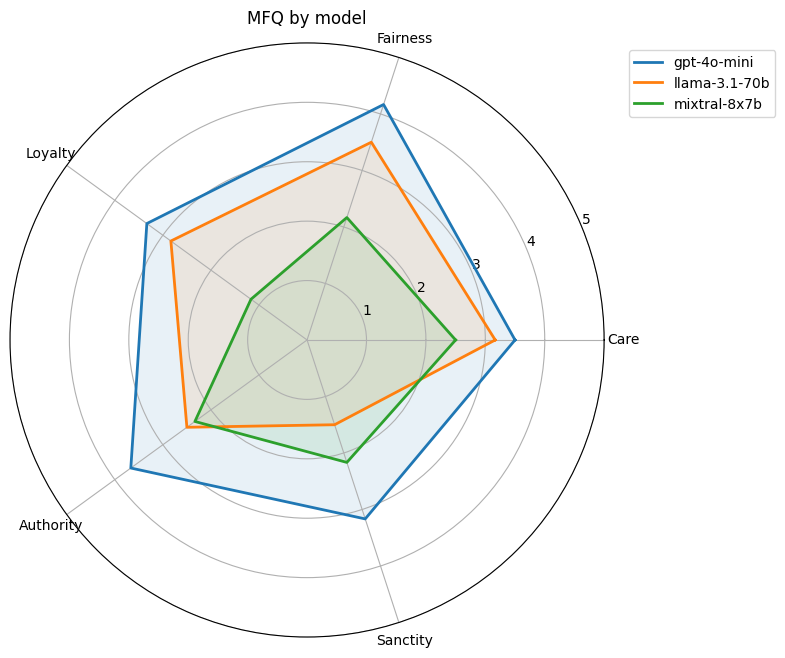

In [186]:
# Example usage:
plot_radar_chart([all_scores['gpt-4o-mini'][:5], all_scores['llama-3.1-70b'][:5], all_scores['mixtral-8x7b'][:5]], ["gpt-4o-mini", "llama-3.1-70b", "mixtral-8x7b"])